In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.family'] = ['Tahoma', 'DejaVu Sans']

def reshape_arabic(text):
    """Reshape Arabic text for proper display in plots"""
    if pd.isna(text):
        return ""
    reshaped = arabic_reshaper.reshape(str(text))
    return get_display(reshaped)

In [4]:
df = pd.read_csv("Arabic_Poetry_Dataset.csv", encoding='utf-8')

1. DATASET OVERVIEW
--------------------------------------------------

In [5]:
print(f"Total number of records: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")

Total number of records: 75,022
Number of columns: 6

Column names: ['poet_name', 'poet_era', 'poem_tags', 'poem_title', 'poem_text', 'poem_count']

Data types:
poet_name     object
poet_era      object
poem_tags     object
poem_title    object
poem_text     object
poem_count    object
dtype: object


2. MISSING DATA ANALYSIS
--------------------------------------------------

    Column  Missing_Count  Missing_Percentage
poem_count           1012                1.35
 poem_text           1012                1.35
 poem_tags             32                0.04
poem_title              2                0.00


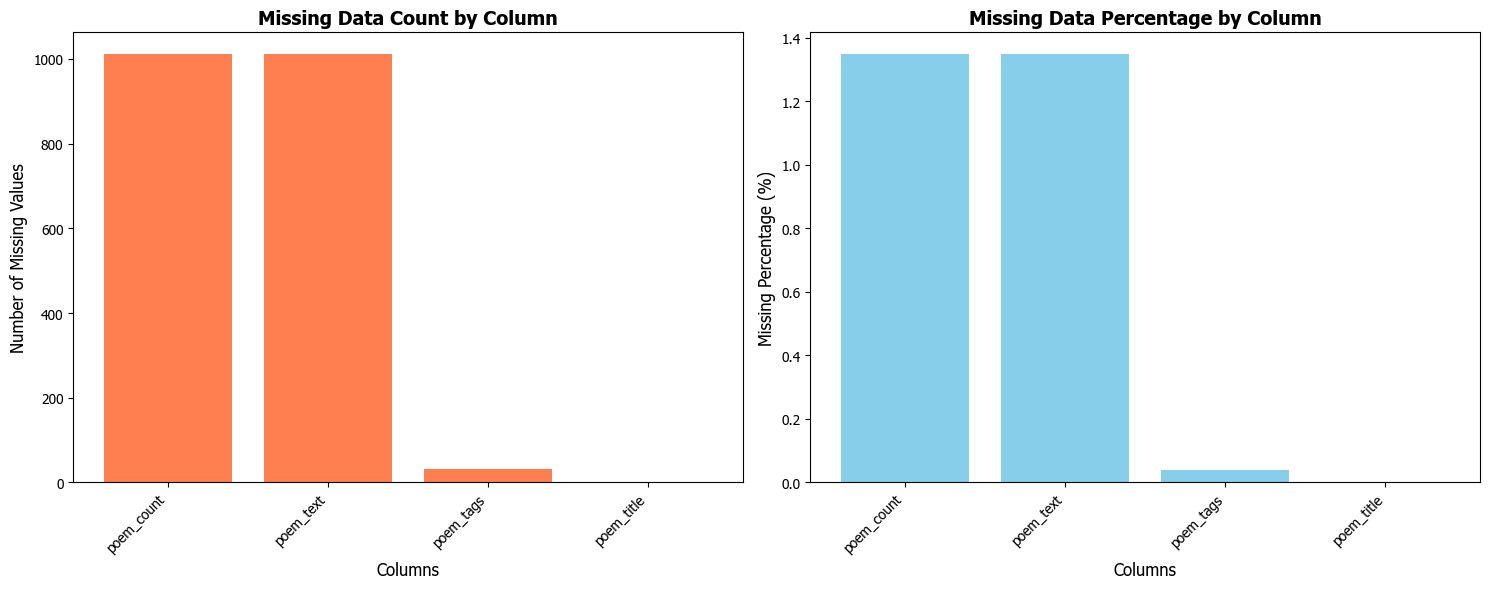

In [6]:
missing_counts = df.isnull().sum()
missing_percentages = ((missing_counts / len(df)) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentages.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.bar(range(len(missing_df)), missing_df['Missing_Count'], color='coral')
ax1.set_xlabel('Columns', fontsize=12)
ax1.set_ylabel('Number of Missing Values', fontsize=12)
ax1.set_title('Missing Data Count by Column', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(missing_df)))
ax1.set_xticklabels(missing_df['Column'], rotation=45, ha='right')

ax2.bar(range(len(missing_df)), missing_df['Missing_Percentage'], color='skyblue')
ax2.set_xlabel('Columns', fontsize=12)
ax2.set_ylabel('Missing Percentage (%)', fontsize=12)
ax2.set_title('Missing Data Percentage by Column', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(missing_df)))
ax2.set_xticklabels(missing_df['Column'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


3. ERA DISTRIBUTION ANALYSIS
--------------------------------------------------

Rows after removing missing poem_text/poet_era: 74,010 (98.7%)

Poems per era:
  العصر الأندلسي: 6,083 (8.2%)
  العصر الاسلامي: 271 (0.4%)
  العصر الاموي: 7,059 (9.5%)
  العصر الايوبي: 8,097 (10.9%)
  العصر الجاهلي: 2,307 (3.1%)
  العصر العباسي: 26,515 (35.8%)
  العصر العثماني: 7,487 (10.1%)
  العصر المملوكي: 13,066 (17.7%)
  المخضرمون: 3,125 (4.2%)


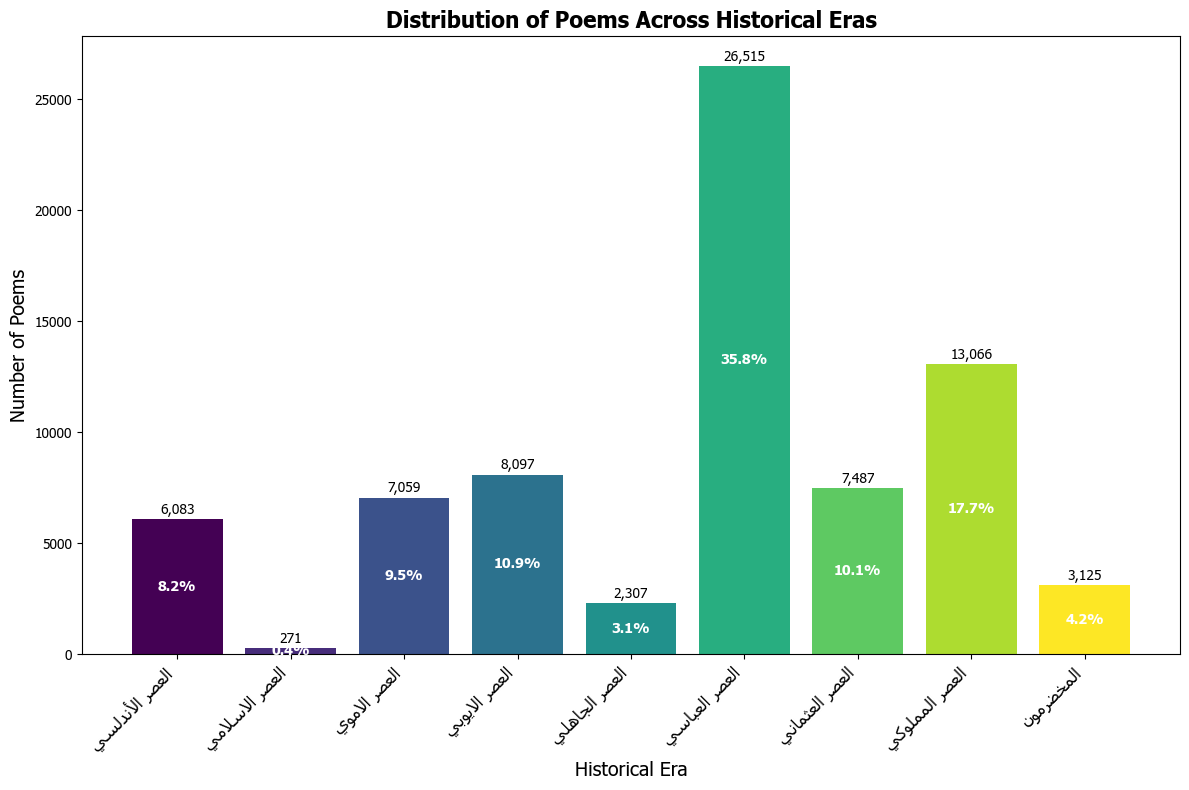

Class imbalance ratio: 97.8:1
Largest class: العصر العباسي (26,515 poems)
Smallest class: العصر الاسلامي (271 poems)


In [7]:
# Remove rows with missing poem_text or poet_era
df_clean = df.dropna(subset=['poem_text', 'poet_era']).copy()
print(f"Rows after removing missing poem_text/poet_era: {len(df_clean):,} ({len(df_clean)/len(df)*100:.1f}%)")

era_counts = df_clean['poet_era'].value_counts().sort_index()
print("\nPoems per era:")
for era, count in era_counts.items():
    print(f"  {era}: {count:,} ({count/len(df_clean)*100:.1f}%)")

# Visualize era distribution
plt.figure(figsize=(12, 8))
eras = [reshape_arabic(era) for era in era_counts.index]
counts = era_counts.values
colors = plt.cm.viridis(np.linspace(0, 1, len(era_counts)))

bars = plt.bar(range(len(eras)), counts, color=colors)
plt.xlabel('Historical Era', fontsize=14)
plt.ylabel('Number of Poems', fontsize=14)
plt.title('Distribution of Poems Across Historical Eras', fontsize=16, fontweight='bold')
plt.xticks(range(len(eras)), eras, rotation=45, ha='right', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars, counts)):
    percentage = count / sum(counts) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
             f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.show()


max_class = era_counts.max()
min_class = era_counts.min()
print(f"Class imbalance ratio: {max_class/min_class:.1f}:1")
print(f"Largest class: {era_counts.idxmax()} ({max_class:,} poems)")
print(f"Smallest class: {era_counts.idxmin()} ({min_class:,} poems)")


4. POEM LENGTH ANALYSIS
--------------------------------------------------

Overall poem length statistics:
  Lines - Mean: 23.1, Median: 9, Std: 42.8
  Words - Mean: 104.4, Median: 39, Std: 201.3
  Words/Line - Mean: 4.1

Long poems (>100 lines): 3235 (4.37%)


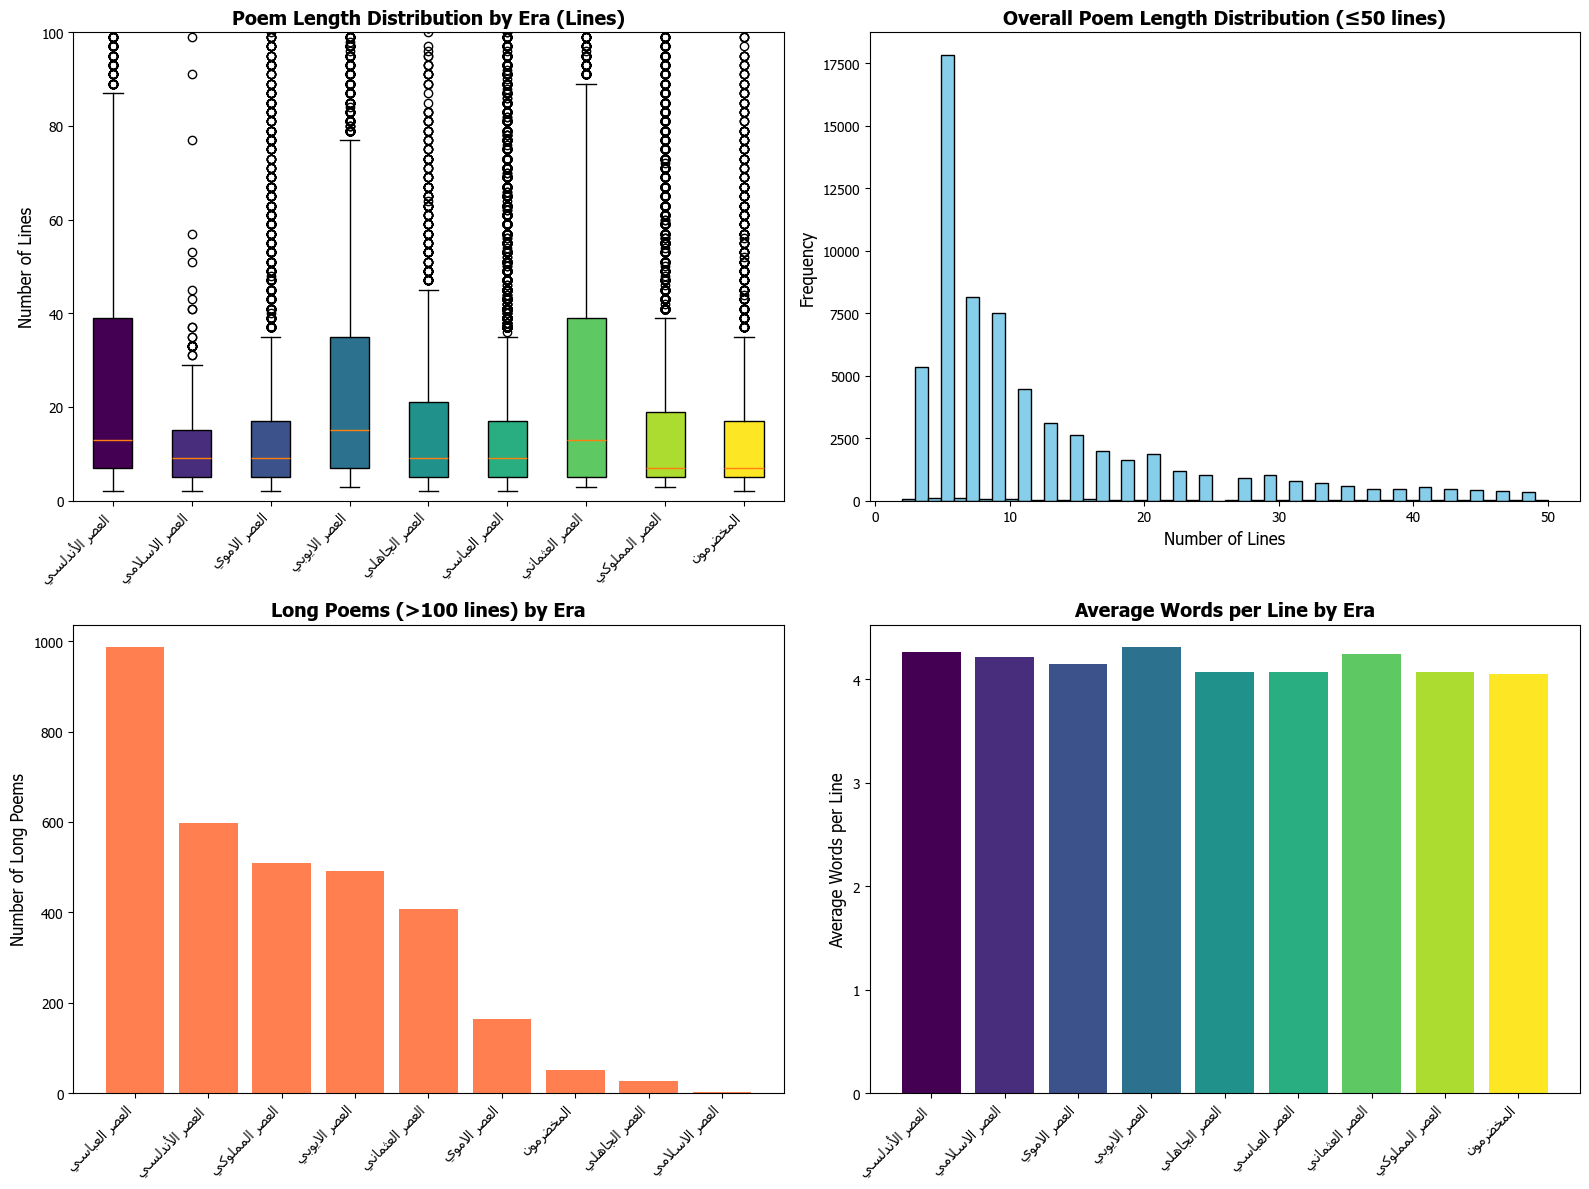

In [8]:
# Calculate poem lengths (in lines and words)
df_clean['num_lines'] = df_clean['poem_text'].str.count('\n') + 1
df_clean['num_words'] = df_clean['poem_text'].str.split().str.len()
df_clean['avg_words_per_line'] = df_clean['num_words'] / df_clean['num_lines']

# Overall statistics
print("Overall poem length statistics:")
print(f"  Lines - Mean: {df_clean['num_lines'].mean():.1f}, Median: {df_clean['num_lines'].median():.0f}, "
      f"Std: {df_clean['num_lines'].std():.1f}")
print(f"  Words - Mean: {df_clean['num_words'].mean():.1f}, Median: {df_clean['num_words'].median():.0f}, "
      f"Std: {df_clean['num_words'].std():.1f}")
print(f"  Words/Line - Mean: {df_clean['avg_words_per_line'].mean():.1f}")

# Length distribution by era
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot of lines by era
ax = axes[0, 0]
era_order = era_counts.index.tolist()
era_labels = [reshape_arabic(era) for era in era_order]
df_clean['era_reshaped'] = df_clean['poet_era'].apply(reshape_arabic)

# Prepare data for boxplot
data_for_box = [df_clean[df_clean['poet_era'] == era]['num_lines'].values for era in era_order]
bp = ax.boxplot(data_for_box, labels=era_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticklabels(era_labels, rotation=45, ha='right')
ax.set_ylabel('Number of Lines', fontsize=12)
ax.set_title('Poem Length Distribution by Era (Lines)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)  # Focus on typical range

# Histogram of overall length distribution
ax = axes[0, 1]
ax.hist(df_clean['num_lines'][df_clean['num_lines'] <= 50], bins=50, color='skyblue', edgecolor='black')
ax.set_xlabel('Number of Lines', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Overall Poem Length Distribution (≤50 lines)', fontsize=14, fontweight='bold')

# Identify long poems
long_poem_threshold = 100
long_poems = df_clean[df_clean['num_lines'] > long_poem_threshold]
print(f"\nLong poems (>{long_poem_threshold} lines): {len(long_poems)} ({len(long_poems)/len(df_clean)*100:.2f}%)")

# Long poems by era
ax = axes[1, 0]
long_poems_by_era = long_poems['poet_era'].value_counts()
if len(long_poems_by_era) > 0:
    x_pos = range(len(long_poems_by_era))
    ax.bar(x_pos, long_poems_by_era.values, color='coral')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([reshape_arabic(era) for era in long_poems_by_era.index], rotation=45, ha='right')
    ax.set_ylabel('Number of Long Poems', fontsize=12)
    ax.set_title(f'Long Poems (>{long_poem_threshold} lines) by Era', fontsize=14, fontweight='bold')

# Average words per line by era
ax = axes[1, 1]
avg_wpl_by_era = df_clean.groupby('poet_era')['avg_words_per_line'].mean().loc[era_order]
ax.bar(range(len(era_order)), avg_wpl_by_era.values, color=colors)
ax.set_xticks(range(len(era_order)))
ax.set_xticklabels(era_labels, rotation=45, ha='right')
ax.set_ylabel('Average Words per Line', fontsize=12)
ax.set_title('Average Words per Line by Era', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


5. METADATA ANALYSIS - POEM TAGS
--------------------------------------------------

Poems with tags: 73,978 (100.0%)


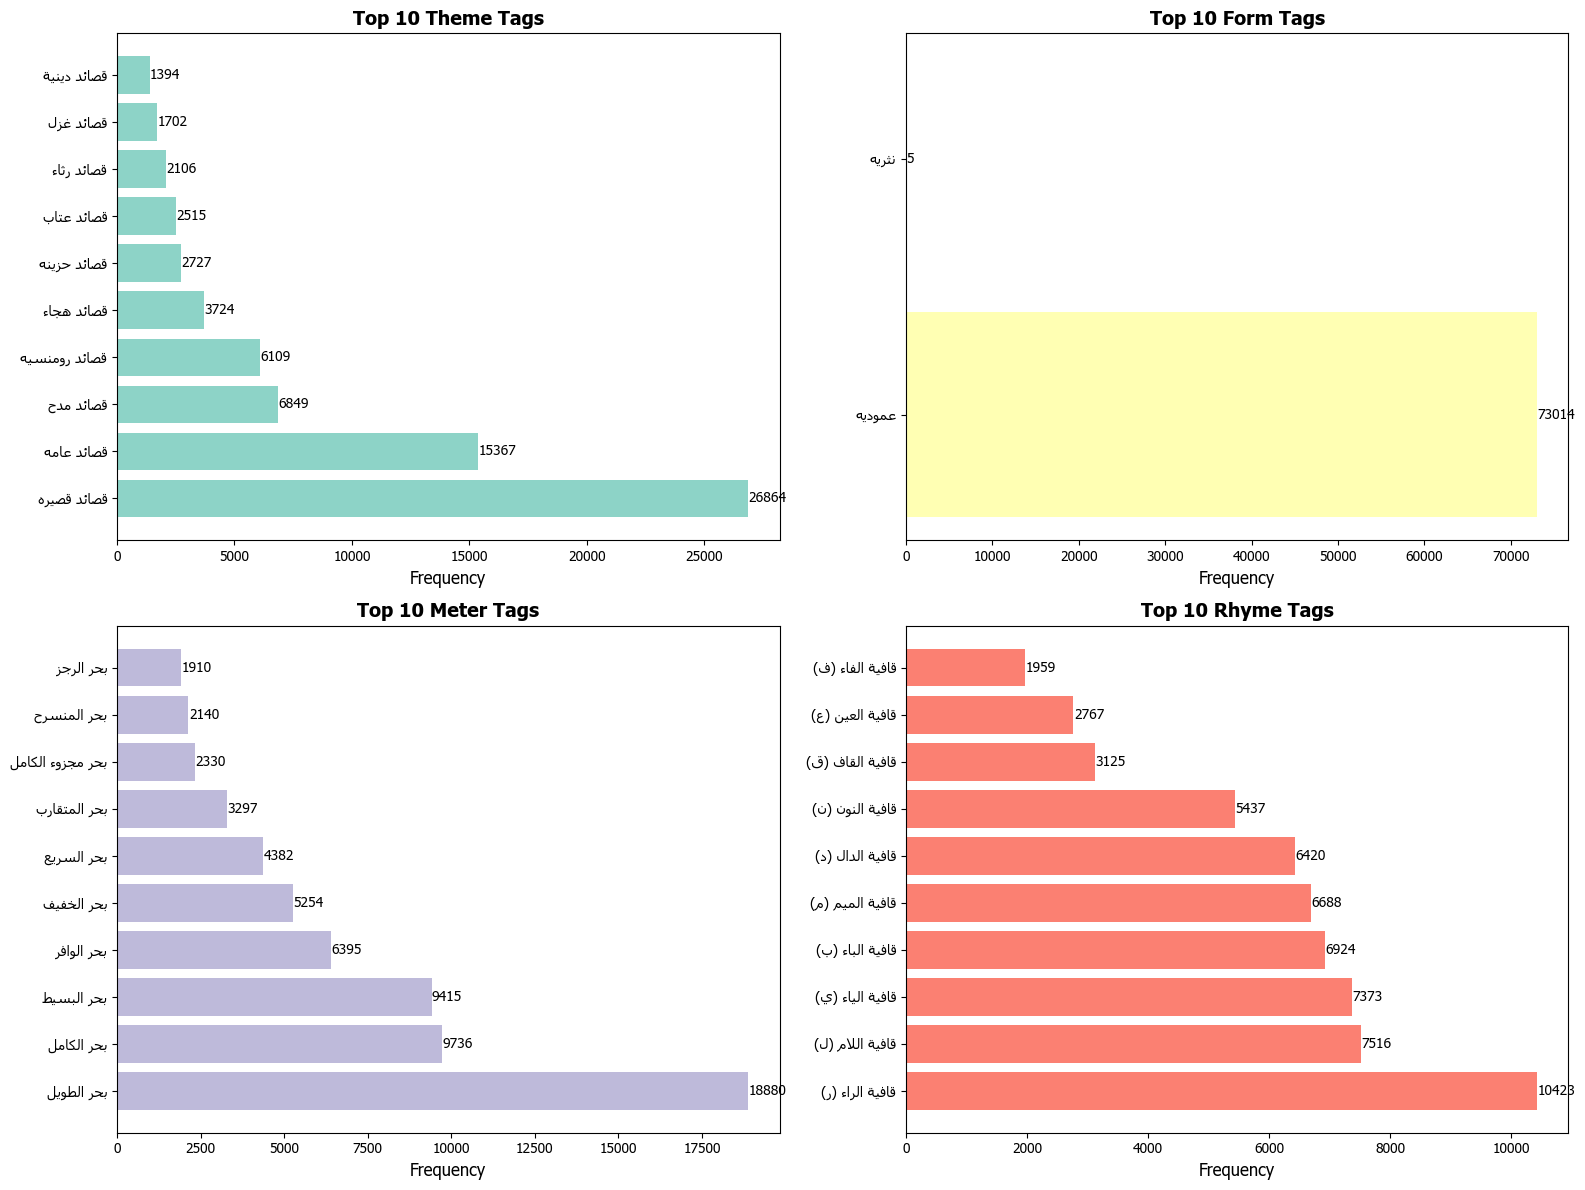

In [9]:
# Analyze poem tags
df_with_tags = df_clean.dropna(subset=['poem_tags'])
print(f"Poems with tags: {len(df_with_tags):,} ({len(df_with_tags)/len(df_clean)*100:.1f}%)")

# Extract all tags
all_tags = []
for tags in df_with_tags['poem_tags'].dropna():
    # Split by both Arabic and Latin commas
    parts = re.split('[,،]', str(tags))
    all_tags.extend([t.strip() for t in parts if t.strip()])

# Categorize tags
def categorize_tag(tag):
    if 'بحر' in tag:
        return 'meter'
    elif 'قافية' in tag or 'قافيه' in tag:
        return 'rhyme'
    elif any(word in tag for word in ['عمودي', 'موشح', 'زجل', 'مقطوع', 'رباعي', 'التفعيلة', 'نثري']):
        return 'form'
    else:
        return 'theme'

tag_categories = defaultdict(Counter)
for tag in all_tags:
    category = categorize_tag(tag)
    tag_categories[category][tag] += 1

# Display top tags by category
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (category, tags) in enumerate(tag_categories.items()):
    if idx >= 4:
        break
    
    ax = axes[idx]
    top_tags = tags.most_common(10)
    
    if top_tags:
        tags_list = [reshape_arabic(tag) for tag, _ in top_tags]
        counts_list = [count for _, count in top_tags]
        
        bars = ax.barh(range(len(tags_list)), counts_list, color=plt.cm.Set3(idx))
        ax.set_yticks(range(len(tags_list)))
        ax.set_yticklabels(tags_list)
        ax.set_xlabel('Frequency', fontsize=12)
        ax.set_title(f'Top 10 {category.title()} Tags', fontsize=14, fontweight='bold')
        
        # Add count labels
        for i, (bar, count) in enumerate(zip(bars, counts_list)):
            ax.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
                   f'{count}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


6. POET ANALYSIS
--------------------------------------------------

Total number of poets: 748

Top 10 most prolific poets:
                    poem_count             era  avg_lines  std_lines  min_lines  max_lines
poet_name                                                                                 
ابن الرومي                2016   العصر العباسي      30.89      57.72          2        673
ابن نباته المصري          1727  العصر المملوكي      16.39      27.70          3        335
أبو العلاء المعري         1611   العصر العباسي      15.76      16.74          5        193
ابن الوردي                1233  العصر المملوكي       7.92      14.12          3        183
ابو نواس                  1174   العصر العباسي      16.06      12.00          4        101
الشريف العقيلي             983  العصر المملوكي       9.05      10.40          3        245
عبد الغني النابلسي         967  العصر العثماني      28.62      31.05          3        425
البحتري                    931   العصر العباسي      34.96      30.27          3        179
محيي الدين بن عربي         901   ا

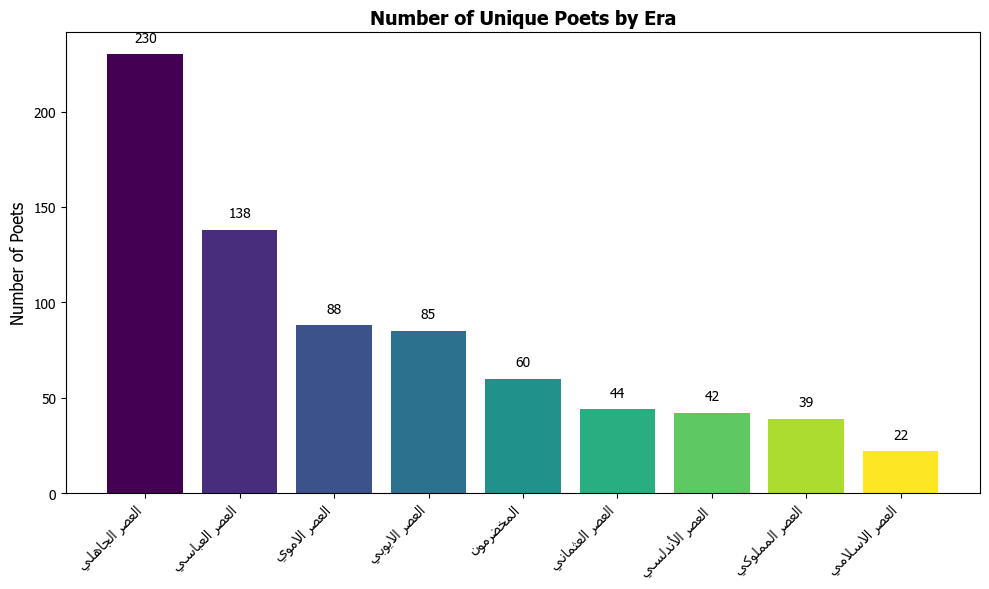

In [10]:
poet_stats = df_clean.groupby('poet_name').agg({
    'poem_title': 'count',
    'poet_era': 'first',
    'num_lines': ['mean', 'std', 'min', 'max']
}).round(2)

poet_stats.columns = ['poem_count', 'era', 'avg_lines', 'std_lines', 'min_lines', 'max_lines']
poet_stats = poet_stats.sort_values('poem_count', ascending=False)

print(f"Total number of poets: {len(poet_stats):,}")
print(f"\nTop 10 most prolific poets:")
print(poet_stats.head(10).to_string())

# Poets per era
poets_per_era = df_clean.groupby('poet_era')['poet_name'].nunique().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
x_pos = range(len(poets_per_era))
bars = plt.bar(x_pos, poets_per_era.values, color=colors)
plt.xticks(x_pos, [reshape_arabic(era) for era in poets_per_era.index], rotation=45, ha='right')
plt.ylabel('Number of Poets', fontsize=12)
plt.title('Number of Unique Poets by Era', fontsize=14, fontweight='bold')

for bar, count in zip(bars, poets_per_era.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{count}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


7. TEXT QUALITY ANALYSIS
--------------------------------------------------

In [11]:
# Check for very short poems
very_short_threshold = 2
very_short_poems = df_clean[df_clean['num_lines'] <= very_short_threshold]
print(f"Very short poems (≤{very_short_threshold} lines): {len(very_short_poems)} "
      f"({len(very_short_poems)/len(df_clean)*100:.2f}%)")

# Check for duplicate poems
duplicate_poems = df_clean[df_clean.duplicated(subset=['poem_text'], keep=False)]
print(f"Duplicate poems: {len(duplicate_poems)} ({len(duplicate_poems)/len(df_clean)*100:.2f}%)")

# Check for poems with unusual characters
def has_non_arabic(text):
    # Check for non-Arabic characters (excluding punctuation and numbers)
    non_arabic_pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\s\d\.\,\;\:\!\?\-\n]')
    return bool(non_arabic_pattern.search(str(text)))

poems_with_non_arabic = df_clean[df_clean['poem_text'].apply(has_non_arabic)]
print(f"Poems with non-Arabic characters: {len(poems_with_non_arabic)} "
      f"({len(poems_with_non_arabic)/len(df_clean)*100:.2f}%)")

Very short poems (≤2 lines): 80 (0.11%)
Duplicate poems: 738 (1.00%)
Poems with non-Arabic characters: 21 (0.03%)


8. SUMMARY STATISTICS BY ERA
--------------------------------------------------------------------------------

In [12]:
summary_stats = df_clean.groupby('poet_era').agg({
    'poem_title': 'count',
    'poet_name': 'nunique',
    'num_lines': ['mean', 'median', 'std', 'min', 'max'],
    'num_words': ['mean', 'median']
}).round(2)

summary_stats.columns = ['poems', 'poets', 'mean_lines', 'median_lines', 'std_lines', 
                        'min_lines', 'max_lines', 'mean_words', 'median_words']
summary_stats['poems_per_poet'] = (summary_stats['poems'] / summary_stats['poets']).round(1)

print(summary_stats.to_string())


                poems  poets  mean_lines  median_lines  std_lines  min_lines  max_lines  mean_words  median_words  poems_per_poet
poet_era                                                                                                                         
العصر الأندلسي   6083     42       32.94          13.0      41.97          2        389      151.12          58.0           144.8
العصر الاسلامي    271     22       13.59           9.0      15.53          2        111       61.57          37.0            12.3
العصر الاموي     7059     88       17.04           9.0      26.62          2        563       77.92          34.0            80.2
العصر الايوبي    8097     85       29.48          15.0      42.67          3       1521      135.29          62.0            95.3
العصر الجاهلي    2307    230       17.33           9.0      21.54          2        255       77.07          40.0            10.0
العصر العباسي   26513    138       20.79           9.0      46.00          2       4735   

9. DATA QUALITY RECOMMENDATIONS
--------------------------------------------------------------------------------
Based on the EDA, the following preprocessing steps are recommended:
1. Remove 1012 poems with missing text
2. Handle 3235 very long poems (>100 lines) - consider segmentation for minority classes
3. Address class imbalance - smallest class has only 271 samples
4. Remove 369 duplicate poems
5. Investigate 21 poems with non-Arabic characters
6. Consider removing 80 very short poems (≤2 lines)
7. Remove any the form 'عمودي' because it's in almost all poems